<a href="https://colab.research.google.com/github/bumiilove/Image-Classifiaction-examples/blob/main/%5BCNN%5DCIFAR_10_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 필요한 라이브러리 임포트
아래 코드는 실습에 필요한 라이브러리들을 임포트하는 부분입니다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary as summary
import torch.nn.init as init

import matplotlib.pyplot as plt
import numpy as np

## 2. Training 환경 설정

아래 코드는 학습 환경을 설정하는 부분입니다. 각 변수의 역할을 설명하면 다음과 같습니다.

- `DEVICE`: 학습에 사용할 장치를 설정합니다. GPU가 사용 가능한 경우 'cuda:0'으로 설정하고, 그렇지 않은 경우 CPU로 설정합니다.
- `BATCH_SIZE`: 한 번에 학습에 사용할 데이터 개수입니다.
- `EPOCHS`: 전체 데이터를 몇 번 반복하여 학습할 것인지 설정합니다.

위 코드를 실행하고 출력된 PyTorch 버전과 사용한 장치 정보를 확인합니다.

In [ ]:
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

batch_size = 32
EPOCHS = 15

input=(32,32)

print('Set batch: {}, epoch : {}'.format(batch_size, EPOCHS))
print('Using PyTorch version: ', torch.__version__, 'Device: ', device)

Set batch: 32, epoch : 15
Using PyTorch version:  2.0.1+cu118 Device:  cuda:0


## 3. 데이터셋 및 데이터로더 설정
<details>
<summary>아래 코드는 CIFAR-10 데이터셋을 다운로드하고 데이터로더를 설정하는 부분입니다. 각 변수의 역할을 설명하면 다음과 같습니다.</summary>

- `transform`: 데이터셋의 이미지에 대한 변환을 정의합니다. 먼저 transforms.ToTensor()를 사용하여 이미지를 텐서로 변환하고,
그런 다음 transforms.Normalize()를 통해 이미지를 정규화합니다. 이 정규화는 평균과 표준편차를 활용하여 이미지의 값 범위를 [0, 1]로 조정합니다.

- `trainset`: 학습에 사용할 CIFAR-10 데이터셋을 정의합니다. 이 데이터셋은 루트 디렉토리를 './data'로 설정하고, train=True로 지정하여 학습 데이터를 가져옵니다. 이미지 변환은 앞서 정의한 transform을 사용합니다.

- `testset`: 테스트에 사용할 CIFAR-10 데이터셋을 정의합니다. 이 데이터셋은 train=False로 설정하여 테스트 데이터를 가져옵니다. 이미지 변환은 역시 transform을 사용합니다.

- `valset`: 검증(Validation) 데이터셋으로 사용할 CIFAR-10 데이터셋을 정의합니다. 테스트 데이터셋과 동일한 설정을 가지며, 주로 모델의 성능을 평가하기 위해 사용됩니다.

- `train_loader`: 학습 데이터셋을 미니배치로 나누어 로딩하기 위한 데이터로더를 설정합니다. batch_size 변수로 한 번에 사용할 데이터 개수를 설정하고, shuffle=True로 데이터를 에포크(epoch)마다 섞어 모델 학습에 활용합니다. num_workers는 데이터 로딩을 병렬로 처리할 워커(worker)의 수를 나타냅니다.

- `test_loader`: 테스트 데이터셋을 미니배치로 나누어 로딩하기 위한 데이터로더를 설정합니다. 마찬가지로 batch_size로 한 번에 사용할 데이터 개수를 설정하고, shuffle=False로 데이터를 섞지 않고 로드합니다.

- `val_loader` : 검증 데이터셋을 미니배치로 나누어 로딩하기 위한 데이터로더를 설정합니다. 테스트 데이터 로더와 유사한 설정을 가지며, 주로 모델 성능 검증에 사용됩니다.

- `classes` : CIFAR-10 데이터셋의 클래스 레이블을 정의합니다. 이 데이터셋에는 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' 등 10개의 클래스가 있습니다.
</details>

In [ ]:
# Dataset and Dataloader by PyTorch
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### 데이터 확인

In [ ]:
for (X_train, Y_train) in train_loader:
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('Y_train: ', Y_train.size(), 'type: ', Y_train.type())
    print('Label examples : ',Y_train)
    break

X_train:  torch.Size([32, 3, 32, 32]) type:  torch.FloatTensor
Y_train:  torch.Size([32]) type:  torch.LongTensor
Label examples :  tensor([7, 7, 8, 2, 1, 4, 5, 7, 9, 3, 7, 7, 8, 0, 6, 9, 3, 6, 1, 3, 4, 5, 4, 2,
        5, 5, 2, 0, 9, 7, 8, 0])


### 데이터 시각화

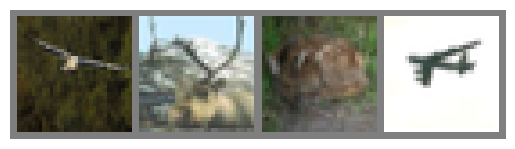


bird                deer                deer                plane          


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    # plt.figure(figsize=(10, 14))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print('Labels of a batch')
print()
print('     '.join(f'{classes[labels[j]]:15s}' for j in range(batch_size)))

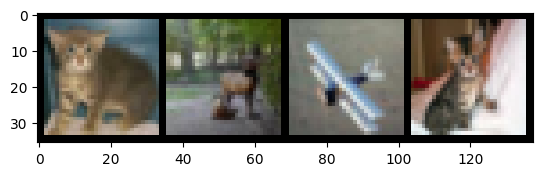

In [ ]:
for data in train_loader:
    img, label = data
    plt.imshow(torchvision.utils.make_grid(img, normalize=True).permute(1,2,0))
    plt.show()
    break

  ## 2. 모델 설계 (Architecture design)
  CIFAR-10 분류에서는 CNN 아키텍쳐를 활용해서 진행해봅니다.

In [ ]:
# Model & Inference in PyTorch
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv3 = nn.Conv2d(64, 64, 3)
    self.fc1 = nn.Linear(64*4*4, 64)
    self.fc2 = nn.Linear(64, 10)
    self.dropout = nn.Dropout(p=0.35)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)

    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)

    x = self.conv3(x)
    x = F.relu(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.dropout(x)
    x = F.relu(x)


    x = self.fc2(x)

    return x

model = ConvNet().to(device)

## Loss  and Optimization setting

In [ ]:
# Loss and Optimizer in PyTorch
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Creat list used in plot
train_accuracies = []  # List of training acc
train_losses = []
val_accuracies = []    # List of val acc
val_losses = []

In [ ]:
def showModelInfo(model, input=(28,28)):
    for name, param in model.named_parameters():
        print(name, param.size())
    print()
    print(model.named_children())
    print(summary(model, input, batch_size = 32))

def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

In [ ]:
showModelInfo(model, input=(3, 32, 32))

conv1.weight torch.Size([32, 3, 3, 3])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 3, 3])
conv2.bias torch.Size([64])
conv3.weight torch.Size([64, 64, 3, 3])
conv3.bias torch.Size([64])
fc1.weight torch.Size([64, 1024])
fc1.bias torch.Size([64])
fc2.weight torch.Size([10, 64])
fc2.bias torch.Size([10])

<generator object Module.named_children at 0x78a26738af80>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 32, 30, 30]             896
         MaxPool2d-2           [32, 32, 15, 15]               0
            Conv2d-3           [32, 64, 13, 13]          18,496
         MaxPool2d-4             [32, 64, 6, 6]               0
            Conv2d-5             [32, 64, 4, 4]          36,928
            Linear-6                   [32, 64]          65,600
           Dropout-7                   [32, 64]               0
            Linear-8                   [32

## Training and Evaluation

In [ ]:
# Training in PyTorch
steps_per_epoch = len(train_loader)

for epoch in range(EPOCHS):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    # ---------------------- train --------------------------------------#
    model.train()  # Set Model to Learning Mode
    for (inputs, labels) in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / steps_per_epoch
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)  # Store the accuracy of the learning dataset for each epoch

    # Loss and accuracy output for learning data
    print(f'Epoch [{epoch + 1}/{15}] Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%')

    # ---------------------- Evaluation --------------------------------------#
    # Perform an evaluation of verification data
    model.eval()  # Put the model into evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for (inputs, labels) in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)  # Store verification dataset accuracy for each epoch

    # Loss and accuracy output for verification data
    print(f'Epoch [{epoch + 1}/{15}] Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/15] Train Loss: 0.646, Train Accuracy: 77.21%
Epoch [1/15] Validation Loss: 0.846, Validation Accuracy: 72.04%
Epoch [2/15] Train Loss: 0.636, Train Accuracy: 77.41%
Epoch [2/15] Validation Loss: 0.840, Validation Accuracy: 72.20%
Epoch [3/15] Train Loss: 0.615, Train Accuracy: 78.19%
Epoch [3/15] Validation Loss: 0.839, Validation Accuracy: 72.82%
Epoch [4/15] Train Loss: 0.601, Train Accuracy: 78.51%
Epoch [4/15] Validation Loss: 0.870, Validation Accuracy: 72.29%
Epoch [5/15] Train Loss: 0.588, Train Accuracy: 78.96%
Epoch [5/15] Validation Loss: 0.919, Validation Accuracy: 71.31%
Epoch [6/15] Train Loss: 0.576, Train Accuracy: 79.22%
Epoch [6/15] Validation Loss: 0.885, Validation Accuracy: 72.53%
Epoch [7/15] Train Loss: 0.563, Train Accuracy: 79.74%
Epoch [7/15] Validation Loss: 0.879, Validation Accuracy: 72.29%
Epoch [8/15] Train Loss: 0.544, Train Accuracy: 80.37%
Epoch [8/15] Validation Loss: 0.900, Validation Accuracy: 72.09%
Epoch [9/15] Train Loss: 0.530, Train Ac

## Model Evaluation

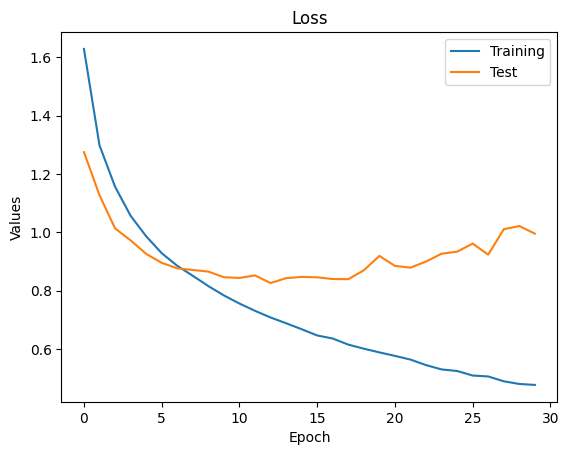

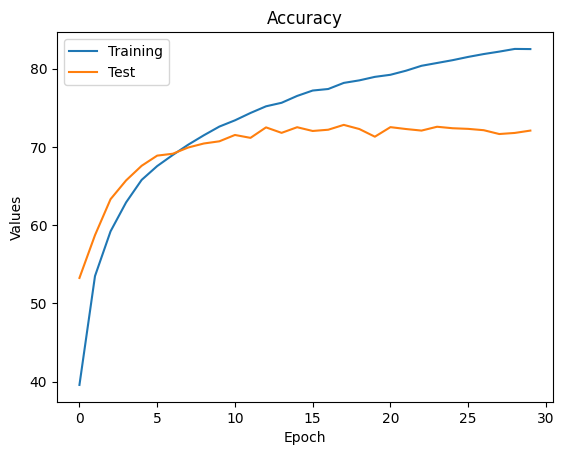

In [ ]:
def rst_plot(value1, value2, title):
    plt.plot(value1, label='Training')
    plt.plot(value2, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.show()

rst_plot(train_losses, val_losses, 'Loss')

rst_plot(train_accuracies, val_accuracies,'Accuracy')

# plt.figure(figsize=(7, 5))
# plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Accuracy', )
# plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val_Accuracy', )
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

## 실습 1-1과 같이 MLP(Multi-layer perceptron)을 이용해서 진행할 수도 있습니다.

In [ ]:
class MultilayerPerceptron(nn.Module):

    def __init__(self, input_size=32*32*3, output_size=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, output_size)
        #self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(-1, 32*32*3)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)

        x = self.fc4(x)
        x = F.relu(x)

        x = self.fc5(x)

        return x

model = MultilayerPerceptron().to(device)

In [ ]:
# Loss and Optimizer in PyTorch
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Creat list used in plot
train_accuracies = []  # List of training acc
train_losses = []
val_accuracies = []    # List of val acc
val_losses = []

In [ ]:
def showModelInfo(model, input=(28,28)):
    for name, param in model.named_parameters():
        print(name, param.size())
    print()
    print(model.named_children())
    print(summary(model, input, batch_size = 32))

def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

In [ ]:
showModelInfo(model, input=(3, 32, 32))
weight_init(model)

fc1.weight torch.Size([120, 3072])
fc1.bias torch.Size([120])
fc2.weight torch.Size([84, 120])
fc2.bias torch.Size([84])
fc3.weight torch.Size([32, 84])
fc3.bias torch.Size([32])
fc4.weight torch.Size([16, 32])
fc4.bias torch.Size([16])
fc5.weight torch.Size([10, 16])
fc5.bias torch.Size([10])

<generator object Module.named_children at 0x78a26e009c40>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [32, 120]         368,760
            Linear-2                   [32, 84]          10,164
            Linear-3                   [32, 32]           2,720
            Linear-4                   [32, 16]             528
            Linear-5                   [32, 10]             170
Total params: 382,342
Trainable params: 382,342
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 0.06

In [ ]:
# Training in PyTorch
steps_per_epoch = len(train_loader)

EPOCHS = 15
for epoch in range(EPOCHS):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # ---------------------- train --------------------------------------#
    model.train()  # Set Model to Learning Mode
    for (inputs, labels) in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / steps_per_epoch
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)  # Store the accuracy of the learning dataset for each epoch

    # Loss and accuracy output for learning data
    print(f'Epoch [{epoch + 1}/{15}] Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%')
    # ---------------------- train --------------------------------------#

    # ---------------------- Evaluation --------------------------------------#
    # Perform an evaluation of verification data
    model.eval()  # Put the model into evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for (inputs, labels) in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)  # Store verification dataset accuracy for each epoch

    # Loss and accuracy output for verification data
    print(f'Epoch [{epoch + 1}/{15}] Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.2f}%')
    # ---------------------- Evaluation --------------------------------------#

Epoch [1/15] Train Loss: 1.079, Train Accuracy: 62.00%
Epoch [1/15] Validation Loss: 1.472, Validation Accuracy: 50.91%
Epoch [2/15] Train Loss: 1.064, Train Accuracy: 62.90%
Epoch [2/15] Validation Loss: 1.557, Validation Accuracy: 50.37%
Epoch [3/15] Train Loss: 1.051, Train Accuracy: 63.23%
Epoch [3/15] Validation Loss: 1.532, Validation Accuracy: 50.65%
Epoch [4/15] Train Loss: 1.039, Train Accuracy: 63.64%
Epoch [4/15] Validation Loss: 1.501, Validation Accuracy: 51.74%
Epoch [5/15] Train Loss: 1.018, Train Accuracy: 64.40%
Epoch [5/15] Validation Loss: 1.510, Validation Accuracy: 51.57%
Epoch [6/15] Train Loss: 1.007, Train Accuracy: 64.95%
Epoch [6/15] Validation Loss: 1.589, Validation Accuracy: 50.75%
Epoch [7/15] Train Loss: 0.989, Train Accuracy: 65.62%
Epoch [7/15] Validation Loss: 1.547, Validation Accuracy: 51.18%
Epoch [8/15] Train Loss: 0.977, Train Accuracy: 65.92%
Epoch [8/15] Validation Loss: 1.580, Validation Accuracy: 50.89%
Epoch [9/15] Train Loss: 0.981, Train Ac

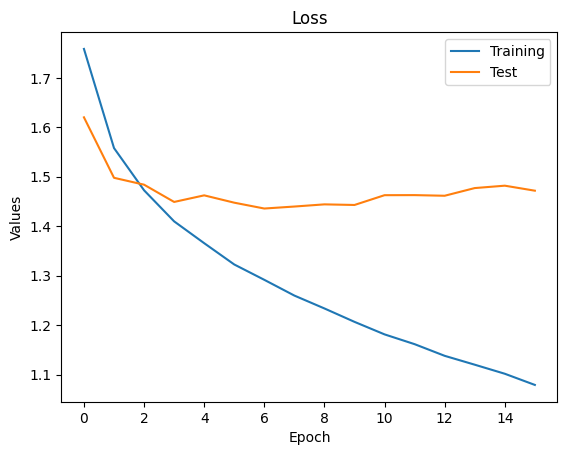

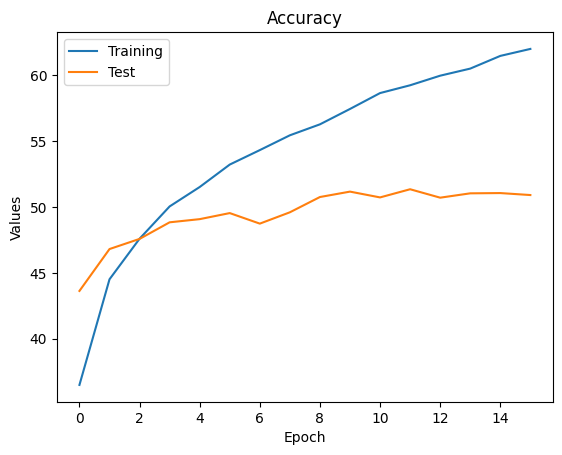

In [ ]:
def rst_plot(value1, value2, title):
    plt.plot(value1, label='Training')
    plt.plot(value2, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.show()

rst_plot(train_losses[:16], val_losses[:16], 'Loss')

rst_plot(train_accuracies[:16], val_accuracies[:16],'Accuracy')

# plt.figure(figsize=(7, 5))
# plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Accuracy', )
# plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val_Accuracy', )
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

## 모델을 이용해 이미지 분류 추론 과정을 진행해봅니다.

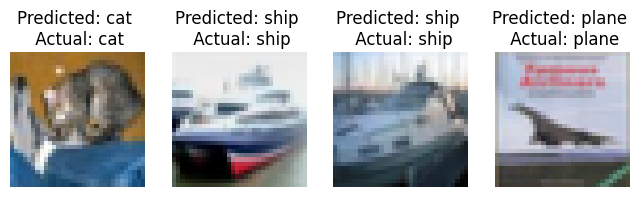

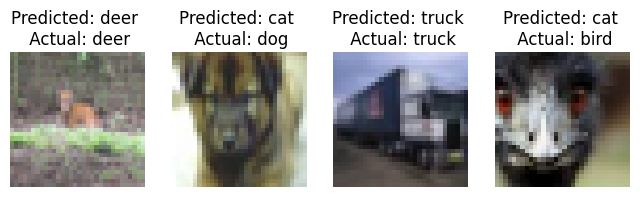

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataloader, device):
    model.eval()
    dataiter = (iter(dataloader))

    for j in range(2):
        images, labels = next(dataiter)
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        plt.figure(figsize=(8, 6))
        for i in range(4):
            plt.subplot(2, 4, i + 1)
            image = images[i] / 2 + 0.5
            image = image.cpu().numpy().transpose((1, 2, 0))
            plt.imshow(image)
            plt.title(f'Predicted: {classes[predicted[i]]} \n Actual: {classes[labels[i]]}')
            plt.axis('off')

    plt.show()

visualize_predictions(model, test_loader, device)


In [ ]:
import torch

inference_num = 4

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    with torch.inference_mode():
            outputs = model(images[:inference_num])
    print(outputs)
    print()
    _, predicted = torch.max(outputs, 1)
    print(torch.max(outputs, 1))
    print(predicted)
    # outputs = model(images)
    # labels
    break

# print(output)


tensor([[-11.6718, -11.2732,  -1.5972,   5.5210,  -4.5377,   4.5282,   1.3286,
          -4.5408, -11.8142, -11.6424],
        [  3.8040,   3.2835, -12.3742, -13.1285, -24.1976, -21.8138, -26.7296,
         -25.2765,   8.1220,  -3.4495],
        [  1.0932,  -4.2218,  -4.9396,  -5.9117,  -7.9871, -11.8494, -10.4718,
         -10.4218,   5.0897,  -2.4599],
        [  6.1675,  -2.3628,  -5.7972, -10.3465,  -7.6709, -11.5895, -18.3227,
         -10.3330,   0.9445,  -2.1849]], device='cuda:0')

torch.return_types.max(
values=tensor([5.5210, 8.1220, 5.0897, 6.1675], device='cuda:0'),
indices=tensor([3, 8, 8, 0], device='cuda:0'))
tensor([3, 8, 8, 0], device='cuda:0')
